## Summary

A model was built to predict which loans have reached a state where they are unlikely to be repaid. This will be useful additional information for deciding which loans to invest in.

### Data Preparation
- Continuous predictors were normalized by subtracting the mean and dividing by the standard deviation (sklearn standard scaler). Missing continuous predictors were imputed with a median value.
- Categorical predictors were one-hot encoded.
- A 50/50 training/test **cross validation split** was performed.
- Since only 9% of the loans were charged off, **SMOTE** was used to handle this class imbalance and create training dataset that has a 50/50 split between the positive and negative class. Without using a resampling method such as SMOTE, models trained on unbalanced data tend to heavily favor predicting the dominant class.

### Models
- Classifier models were used to predict a loan status of **"Charged Off"** (ie. a binary outcome) since these loans are unlikely to be repaid. 
- A **logistic regression** model was trained as a baseline model.
- A **random forest** model was chosen because it considers interactions between the features and can be parallelized easily. The number of trees and tree complexity (minimum sample for split) were set to keep training time reasonable on an old laptop and reduce overfitting.
- Predictors were chosen based on their relevance (ie. credit history seems relevant to loan repayment probability) and explatory data analysis. For instance, there is a lot of variance in the outcome between states (4% in Maine to 11% in Oklahoma) so this was a feature that was included in the model. Some features were created such as the ratio between the income and installment (ie. if someone has a low income relative to the required monthly payment then they may be less likely to repay the loan).
- ROC, precision, and recall (on the test set unless otherwise noted) were used to evaluate the performance of the models. ROC provides a good overall measurement of the performance of the model at all classification thresholds. Additionally lift curves were plotted to examine the utility of the model at different selection thresholds.

### Model Results
- With ROC values of 0.62-0.64 and very low precision (<0.2) in the positive class, neither model performs particularly well. 
- The logistic regression lacks interaction between the features and the random forest model does not have enough trees to avoid overfitting (ROC for the random forest is 0.72 on the training set). 

### Future Work
- **Model inference**: One drawback of this modeling setup is that the sklearn ColumnTransformer preprocessing makes getting the names input features to the models difficult. If reworking this I might opt to use lambda functions to make the necessary imputation and transformations to the variables so that I could give a pandas dataframe to the model. This would make model inference easier since the feature names would be accessible for looking at logistic regression coefficients and variable importance in the random forest model.
- **Optimize hyperparameters**: Train a random forest or gradient boosted model with a larger number of trees to increase performance. Use a Bayesian or random search to optimize hyperparameters such as maximum tree depth, split criteria, the minimum number of samples per split, and the maximum number of features considered in each tree.
- **Feature engineering**: The feature selection and engineering that I did was based on my (fairly limited) knowledge of lending data and this is something I would focus on if pursuing this project further.
- **Experiment with SMOTE**: SMOTE uses k-nearest neighbors to create synthetic instances of the under-represented class. The default k value in imbalanced learn is 5, but this could be optimized.
- Consider grouping the late loan status categories together with the charged off category for prediction, depending on how likely loans that are paid late are likely to be repaid. Another approach would be to use a multiclass classifier such as multinomial logistic regression.

In [1]:
import sys
print(sys.version)

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]


## Data Prep

In [2]:
import pandas as pd
from os import listdir, getcwd
from os.path import isfile, join
pd.set_option('display.max_columns', 500)

In [3]:
def load_data():
    """
    Load all files, return single dataframe
    """
    data_array = [] # placeholder for dataframes
    
    # get filenames
    data_filenames = [ file for file in listdir('data') if isfile(join(getcwd(), 'data', file))]

    for filename in data_filenames:
        full_path = join(getcwd(), 'data', filename)
        print("Loading: " + filename)
        data_array.append(pd.read_csv(full_path))
    
    return(pd.concat(data_array, ignore_index = True))

In [4]:
raw = load_data()
# create boolean variable for charged off loan status
raw['charged_off'] = raw['loan_status'] == 'Charged Off' 

Loading: 2016Q1.csv.gz
Loading: 2016Q2.csv.gz
Loading: 2017Q1.csv.gz
Loading: 2017Q4.csv.gz
Loading: 2017Q2.csv.gz
Loading: 2017Q3.csv.gz
Loading: 2016Q3.csv.gz
Loading: 2016Q4.csv.gz


In [5]:
raw['loan_status'].value_counts(normalize=True)

Current               0.573023
Fully Paid            0.300815
Charged Off           0.093173
Late (31-120 days)    0.018700
In Grace Period       0.009148
Late (16-30 days)     0.005141
Name: loan_status, dtype: float64

In [6]:
raw['id'].drop_duplicates().shape

(438991,)

In [7]:
raw.shape

(438991, 56)

In [8]:
raw['charged_off'].value_counts(normalize = True)

False    0.906827
True     0.093173
Name: charged_off, dtype: float64

In [9]:
raw.shape

(438991, 56)

In [10]:
raw.isna().mean()

id                                0.000000
funded_amnt                       0.000000
term                              0.000000
int_rate                          0.000000
installment                       0.000000
emp_title                         0.069175
emp_length                        0.068368
home_ownership                    0.000000
annual_inc                        0.000000
loan_status                       0.000000
purpose                           0.000000
zip_code                          0.000000
addr_state                        0.000000
dti                               0.000649
delinq_2yrs                       0.000000
earliest_cr_line                  0.000000
fico_range_high                   0.000000
inq_last_6mths                    0.000000
mths_since_last_delinq            0.486743
open_acc                          0.000000
revol_bal                         0.000000
revol_util                        0.000818
total_acc                         0.000000
application

In [11]:
raw['id'].drop_duplicates().shape

(438991,)

In [12]:
raw.sample(3)

,id,funded_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,application_type,annual_inc_joint,dti_joint,open_act_il,open_il_24m,il_util,open_rv_24m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,bc_util,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,charged_off
424851,94046909,16000,60 months,15.99%,389.01,Manager,8 years,MORTGAGE,76000.0,Current,debt_consolidation,273xx,NC,27.55,0,Jan-03,684,0.0,32.0,15,10599,55.20%,26,Individual,NaN,NaN,3.0,1.0,75.0,2.0,67.0,19200,1.0,3,1758.0,82.9,2,20.0,NaN,32.0,0,14,5,15,0,1,96.2,50.0,0,58928,10300,NaN,NaN,NaN,NaN,False
384438,88220983,20000,60 months,25.69%,595.15,Youth Counselor/Kids Manager,10+ years,RENT,100000.0,Charged Off,debt_consolidation,189xx,PA,25.56,0,Jan-01,664,2.0,67.0,22,17992,48%,32,Individual,NaN,NaN,6.0,3.0,68.0,9.0,48.0,37202,5.0,12,2829.0,60.0,1,1.0,69.0,69.0,0,22,11,22,0,8,78.0,85.7,0,87413,19800,NaN,NaN,NaN,NaN,True
83970,83619324,6000,36 months,11.49%,197.83,Event Manager,2 years,RENT,60000.0,Fully Paid,debt_consolidation,606xx,IL,9.86,0,Mar-96,664,4.0,NaN,16,5094,41.40%,38,Individual,NaN,NaN,1.0,0.0,34.0,9.0,37.0,12300,5.0,10,4406.0,53.6,0,0.0,NaN,NaN,0,33,5,12,0,3,100.0,33.3,1,11041,9500,NaN,NaN,NaN,NaN,False


In [13]:
raw.shape

(438991, 56)

In [14]:
raw.groupby('charged_off').mean()

,id,funded_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,revol_bal,total_acc,annual_inc_joint,dti_joint,open_act_il,open_il_24m,il_util,open_rv_24m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,bc_util,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_inq_last_6mths
charged_off,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,9.812409e+07,14709.772187,439.360038,80469.074986,18.885575,0.339731,702.876299,0.513144,33.929309,11.712780,16774.435654,23.860363,118628.621121,18.947470,2.818105,1.546052,69.329273,2.748099,58.238746,35283.068995,2.031198,4.560731,11930.006561,56.347296,1.509946,24.879021,38.129378,34.839391,0.534217,13.634780,5.495698,11.666567,0.089528,2.076485,93.670424,40.360662,0.136070,52445.553444,23699.815599,31566.942160,670.671495,0.656214
True,8.864394e+07,15581.527187,483.271838,73138.351508,20.683411,0.379272,691.799888,0.731871,33.096805,12.073517,15320.527383,24.375727,104296.296232,20.911585,2.869508,1.913323,73.783237,3.481283,62.464275,30080.536013,2.642216,5.636962,8521.885014,60.506480,1.255538,19.790806,37.487617,34.146573,0.567796,14.094934,5.934869,12.014229,0.103296,2.651362,93.656785,45.944068,0.174075,51450.132023,19408.677473,30157.172121,646.909091,1.110303


<AxesSubplot:>

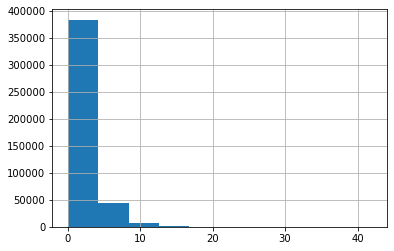

In [15]:
raw['inq_last_12m'].hist()

## EDA

In [16]:
raw['loan_status'].value_counts(dropna = False)

Current               251552
Fully Paid            132055
Charged Off            40902
Late (31-120 days)      8209
In Grace Period         4016
Late (16-30 days)       2257
Name: loan_status, dtype: int64

In [17]:
raw['purpose'].value_counts()[:15]

debt_consolidation    246935
credit_card            91374
home_improvement       32995
other                  30875
major_purchase         10685
medical                 6248
car                     5062
small_business          4930
vacation                3585
moving                  3480
house                   2525
renewable_energy         295
educational                1
wedding                    1
Name: purpose, dtype: int64

<AxesSubplot:>

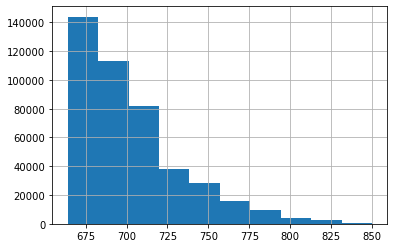

In [18]:
raw['fico_range_high'].hist()

<AxesSubplot:>

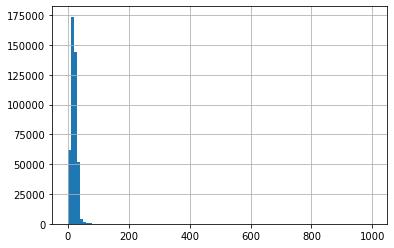

In [19]:
raw['dti'].hist(bins = 100)

In [20]:
raw['application_type'].value_counts(normalize = True)

Individual    0.941208
Joint App     0.058792
Name: application_type, dtype: float64

In [21]:
raw['delinq_2yrs'].value_counts(normalize = True)

0     0.796132
1     0.133406
2     0.040281
3     0.014948
4     0.006617
5     0.003442
6     0.002009
7     0.001098
8     0.000651
9     0.000440
10    0.000312
11    0.000198
12    0.000146
13    0.000096
14    0.000068
15    0.000057
16    0.000032
18    0.000016
17    0.000011
19    0.000009
20    0.000009
21    0.000005
24    0.000002
30    0.000002
22    0.000002
36    0.000002
26    0.000002
25    0.000002
42    0.000002
Name: delinq_2yrs, dtype: float64

In [22]:
raw['pub_rec_bankruptcies'].value_counts(normalize = True)

0    0.870674
1    0.121554
2    0.006030
3    0.001248
4    0.000310
5    0.000116
6    0.000050
7    0.000014
8    0.000005
Name: pub_rec_bankruptcies, dtype: float64

In [23]:
raw['emp_length'].value_counts()

10+ years    148471
2 years       39794
< 1 year      37836
3 years       35018
1 year        29239
5 years       26483
4 years       26208
6 years       18920
9 years       16068
8 years       15892
7 years       15049
Name: emp_length, dtype: int64

In [24]:
raw.groupby('emp_length')['charged_off'].mean()

emp_length
1 year       0.101713
10+ years    0.085956
2 years      0.095542
3 years      0.096779
4 years      0.090392
5 years      0.094891
6 years      0.088425
7 years      0.089375
8 years      0.096589
9 years      0.091175
< 1 year     0.089121
Name: charged_off, dtype: float64

In [25]:
raw.groupby('application_type')['charged_off'].mean()

application_type
Individual    0.095389
Joint App     0.057693
Name: charged_off, dtype: float64

In [26]:
raw.groupby('home_ownership')['charged_off'].mean()

home_ownership
ANY         0.072519
MORTGAGE    0.078881
NONE        0.000000
OWN         0.095502
RENT        0.110315
Name: charged_off, dtype: float64

In [27]:
raw.groupby('addr_state')['charged_off'].mean().sort_values()

addr_state
ME    0.044065
VT    0.056818
DC    0.059244
RI    0.060158
NH    0.065404
OR    0.067023
KS    0.067678
CT    0.069402
WA    0.069757
SC    0.070982
ID    0.075900
CO    0.076782
MT    0.078283
DE    0.079710
WI    0.079871
IL    0.080525
GA    0.080634
WV    0.082902
WY    0.083799
ND    0.085437
UT    0.088508
TN    0.090584
VA    0.091286
NJ    0.092143
HI    0.092308
PA    0.093413
MO    0.093861
TX    0.094188
OH    0.094300
AK    0.094595
MA    0.095587
MD    0.095614
MN    0.095977
MI    0.096119
NC    0.096435
IN    0.096673
KY    0.097839
AZ    0.098203
NM    0.099040
FL    0.099127
NY    0.100543
CA    0.100857
SD    0.104530
MS    0.105117
AL    0.108457
AR    0.111211
NE    0.111273
LA    0.111625
NV    0.114412
OK    0.114489
Name: charged_off, dtype: float64

In [28]:
raw['int_rate']

0         11.99%
1         11.47%
2         16.29%
3         12.99%
4         15.31%
           ...  
438986    17.99%
438987    15.99%
438988    11.39%
438989    10.49%
438990    17.99%
Name: int_rate, Length: 438991, dtype: object

## Feature Engineering

In [29]:
# convert to boolean
raw['delinq_2yrs_bool'] = raw['delinq_2yrs'] > 0
raw['pub_rec_bankruptcies_bool'] = raw['pub_rec_bankruptcies'] > 0
raw['inq_last_12m_bool'] = raw['inq_last_12m'] > 0

# construct ratio variables
#raw['funded_to_installment_ratio'] = raw['funded_amnt'] / raw['installment']
raw['income_to_installment_ratio'] = raw['annual_inc'] / raw['installment']

# remove % and convert to numeric
raw['interest_rate'] = raw['int_rate'].apply(lambda x: x.replace('%', '')).astype(float)

In [30]:
raw.groupby('charged_off')['interest_rate'].mean()

charged_off
False    12.836672
True     16.135767
Name: interest_rate, dtype: float64

In [31]:
raw.groupby('charged_off')['income_to_installment_ratio'].mean() 

charged_off
False    249.557649
True     199.944974
Name: income_to_installment_ratio, dtype: float64

## Build Model

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np
from yellowbrick.regressor import residuals_plot, prediction_error
from yellowbrick.classifier import DiscriminationThreshold, ClassificationReport
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import roc_auc_score
from time import time

set_config(display="diagram")


def class_report(model, test = True):
    """
    Use yellowbrick to get a classifiation report on
    a model for the test datset
    """
    visualizer = ClassificationReport(model)
    if test:
        visualizer.fit(X_test, y_test)
        visualizer.score(X_test, y_test)
    else:
        visualizer.fit(X_train, y_train)
        visualizer.score(X_train, y_train)
    visualizer.show()

def print_time_elapsed(t0):
    """
    Print time elapsed in seconds since time t0
    """
    print("%.1f seconds elapsed" % (time() - t0))
    
def print_roc(model, test = True):
    """
    Print ROC metric for an input the model
    """
    if test:
        roc = roc_auc_score(y_test, model.predict(X_test))
    else:
        roc = roc_auc_score(y_train, model.predict(X_train))
    print(roc)
    
def get_lift_curve(model):
    """
    Return lift curve for a model
    """
    y_probas = model.predict_proba(X_test)
    return plot_lift_curve(y_test, y_probas)

In [33]:
# predictors from the original dataset to include in the models
selected_X_columns = [
    'income_to_installment_ratio', 'purpose', 'home_ownership', 'dti', 'delinq_2yrs_bool', 
    'fico_range_high', 'total_bal_ex_mort', 'application_type', 'pub_rec_bankruptcies_bool',
    'num_tl_op_past_12m', 'addr_state', 'interest_rate'
]
X_orig = raw[selected_X_columns]

In [34]:
X_orig.sample(3)

,income_to_installment_ratio,purpose,home_ownership,dti,delinq_2yrs_bool,fico_range_high,total_bal_ex_mort,application_type,pub_rec_bankruptcies_bool,num_tl_op_past_12m,addr_state,interest_rate
38902,138.879525,debt_consolidation,RENT,24.44,False,704,24192,Individual,False,1,NJ,11.47
185478,92.916942,debt_consolidation,MORTGAGE,11.85,False,719,32931,Individual,False,2,TX,6.72
4396,128.236610,debt_consolidation,MORTGAGE,18.28,False,699,19425,Individual,False,1,MO,9.75


### Preprocessing

In [35]:
# transform categorical and numerical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_orig)
categorical_columns = categorical_columns_selector(X_orig)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
#numerical_preprocessor = StandardScaler()

numeric_transformer = Pipeline([("imputer", 
    SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numeric_transformer, numerical_columns)])

In [36]:
preprocessor

ColumnTransformer(transformers=[('one-hot-encoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['purpose', 'home_ownership',
                                  'application_type', 'addr_state']),
                                ('standard-scaler',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['income_to_installment_ratio', 'dti',
                                  'delinq_2yrs_bool', 'fico_range_high',
                                  'total_bal_ex_mort',
                                  'pub_rec_bankruptcies_bool',
                                  'num_tl_op_past_12m', 'interest_rate'])])

In [37]:
# perform preprocessing on predictors
X = preprocessor.fit_transform(
    X_orig
    )

#y = np.log10(study_df[['total_gmv']].values.ravel())
y = raw[['charged_off']].values.ravel()
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [38]:
preprocessor.transformers_

[('one-hot-encoder',
  OneHotEncoder(handle_unknown='ignore'),
  ['purpose', 'home_ownership', 'application_type', 'addr_state']),
 ('standard-scaler',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler())]),
  ['income_to_installment_ratio',
   'dti',
   'delinq_2yrs_bool',
   'fico_range_high',
   'total_bal_ex_mort',
   'pub_rec_bankruptcies_bool',
   'num_tl_op_past_12m',
   'interest_rate'])]

In [39]:
# Test/Train split
X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X, # predictors
    y, # outcome variable
    test_size = 0.50,
    random_state = 42
)

In [40]:
# Apply SMOTE to get a training dataset with balanced classes
t0 = time()
sm = SMOTE(random_state=42, n_jobs = -1)
X_train, y_train = sm.fit_resample(X_train_raw, y_train_raw)
print_time_elapsed(t0)

27.2 seconds elapsed


In [41]:
np.mean(y_train) # check class imbalance

0.5

## Train Models

In [42]:
# from sklearn.neural_network import MLPClassifier
# nn_model = MLPClassifier(alpha = 0.01, max_iter=100)

In [43]:
# t0 = time()
# # train models
# nn_model.fit(X_train, y_train)
# print_time_elapsed(t0)

In [44]:
# Specify models
lr_model = LogisticRegression(solver='liblinear')
rf_model = RandomForestClassifier(n_jobs=-1, n_estimators=150, min_samples_split=0.04)

In [45]:
t0 = time()
# train models
lr_model.fit(X_train, y_train)
print_time_elapsed(t0)

4.6 seconds elapsed


In [46]:
t0 = time()
rf_model.fit(X_train, y_train)
print_time_elapsed(t0)

46.0 seconds elapsed


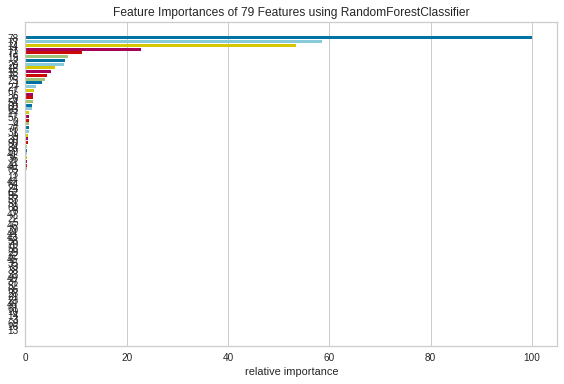

<AxesSubplot:title={'center':'Feature Importances of 79 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [47]:
from yellowbrick.model_selection import FeatureImportances
viz = FeatureImportances(rf_model)
viz.fit(X_train, y_train)
viz.show()

In [48]:
lr_model.coef_

array([[-0.38424462, -0.03063233,  0.03249624,  0.        ,  0.05211618,
        -0.46924506, -0.14221017,  0.06122775,  0.10467457, -0.00577185,
         0.05028146,  0.14067875, -0.12450681,  0.        , -0.97520551,
         0.088245  , -0.31287977,  0.17319234,  0.31151204,  0.13139104,
        -0.84652693,  0.11492937,  0.24770346,  0.31030743,  0.3050194 ,
         0.40525428, -0.13481545, -0.4233842 , -0.32972834, -0.04964497,
         0.29214592, -0.00482725, -0.24711982, -0.47949229,  0.11492781,
         0.27078693, -0.21852817,  0.15065072,  0.38962329,  0.19599339,
         0.17026572, -0.98434499,  0.17765087,  0.18599748,  0.16712009,
         0.19283554, -0.45848293,  0.21314197, -0.04344687,  0.14133974,
        -0.65712336,  0.22277576,  0.16969096,  0.38279199,  0.368449  ,
         0.23369228,  0.44400581, -0.26106218,  0.22122938, -0.58065651,
        -0.38535999, -0.04136337,  0.09512499,  0.34614053, -0.16111963,
         0.16638663, -0.8506059 , -0.23539153,  0.0

## Evaluate Models

In [49]:
print_roc(rf_model)

0.6246676647550102


In [50]:
print_roc(lr_model)

0.644996884170708


In [51]:
# Look at training set performance
print_roc(rf_model, test = False)

0.7235775216775348


In [52]:
# Look at training set performance
print_roc(lr_model, test = False)

0.6532297768444744


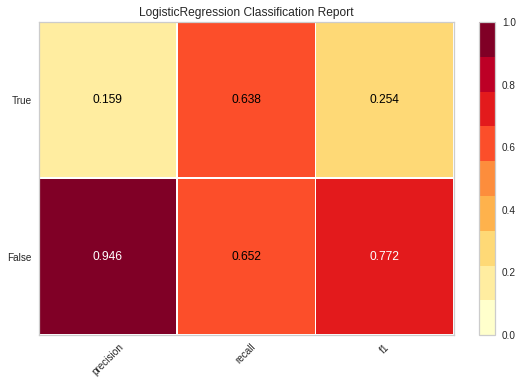

In [53]:
class_report(lr_model)

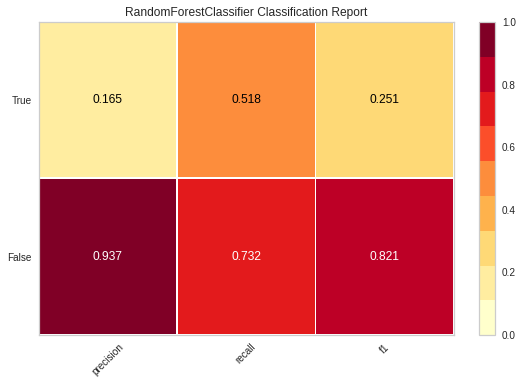

In [54]:
class_report(rf_model)

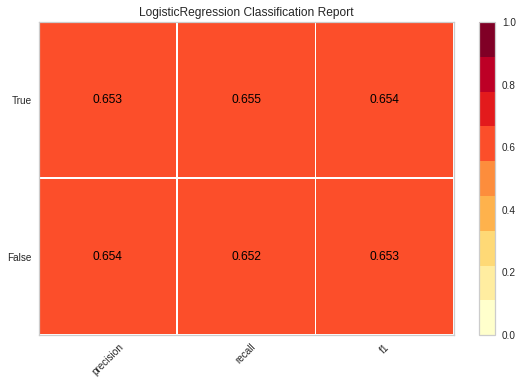

In [55]:
# Look at training set performance
class_report(lr_model, test = False)

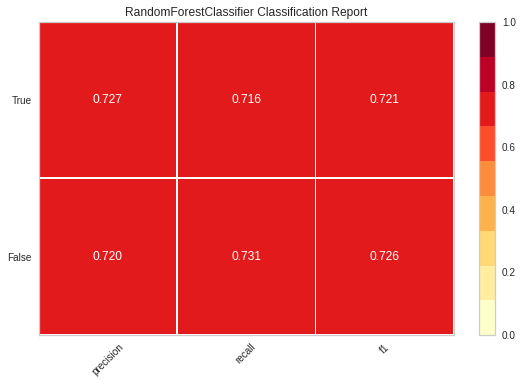

In [56]:
# Look at training set performance
class_report(rf_model, test = False)

## Lift Curve

In [57]:
from scikitplot.metrics import plot_lift_curve

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

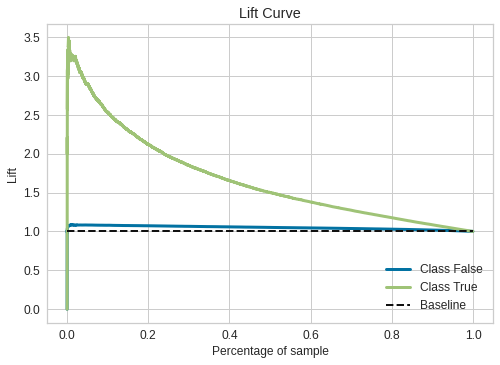

In [58]:
get_lift_curve(lr_model)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

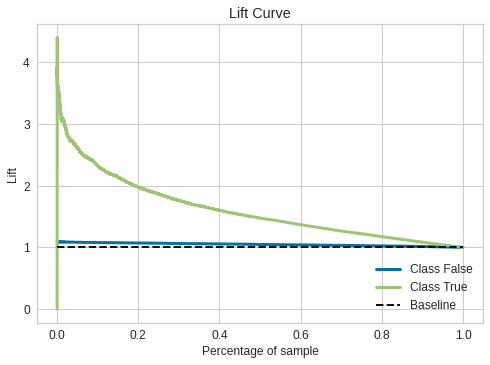

In [59]:
get_lift_curve(rf_model)